## Configure the data loading methods

In [1]:
import pandas as pd
import cv2
import os
from tqdm import tqdm
from PIL import Image

csv_filepath = r'C:\kaggle\plant-pathology-2021-fgvc8\train.csv'
train_im_dir = r'C:\kaggle\plant-pathology-2021-fgvc8\train_images'

### 1. EDA

In [2]:
df = pd.read_csv(csv_filepath)

In [3]:
df.head(10)

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
5,800edef467d27c15.jpg,healthy
6,800f85dc5f407aef.jpg,rust
7,801d6dcd96e48ebc.jpg,healthy
8,801f78399a44e7af.jpg,complex
9,8021b94d437eb7d3.jpg,healthy


In [4]:
n_classes = len(df['labels'].unique())
n_classes

12

### Onehot Encode the labels -> categorial labels

In [5]:
from sklearn.preprocessing import OneHotEncoder

cat = OneHotEncoder()
ohe_encoded = cat.fit_transform(df[['labels']]).toarray()

In [6]:
ohe_encoded.shape

(18632, 12)

In [7]:
im_sizes = []
im_ids = []
labels = []
absolute_im_paths = []

for row in tqdm(df.iterrows(), total=len(df)):
    try:
        # 
        # print(row)
        im_id = row[1][0]
        im_path = os.path.join(train_im_dir, im_id)
        im = Image.open(im_path)
        # im = cv2.imread(im_path)
        h, w = im.size[:2]
        
        im_sizes.append((h, w))
        # print(h, w)
        # break
        im_ids.append(im_id)
        labels.append(row[1][1])
        absolute_im_paths.append(im_path)
    except Exception as e:
        print('failed on im id: {0} with error {1}'.format(im_id, str(e)))

 61%|██████    | 11286/18632 [00:04<00:04, 1545.66it/s]

failed on im id: cd9003bc0be0bafb.jpg with error cannot identify image file 'C:\\kaggle\\plant-pathology-2021-fgvc8\\train_images\\cd9003bc0be0bafb.jpg'
failed on im id: ce5b7057c3259c1c.jpg with error cannot identify image file 'C:\\kaggle\\plant-pathology-2021-fgvc8\\train_images\\ce5b7057c3259c1c.jpg'


100%|██████████| 18632/18632 [00:08<00:00, 2312.83it/s]


In [8]:
df_sizes = pd.DataFrame({'im_sizes': im_sizes, 'id': im_ids, 'label': labels, 'im_path': absolute_im_paths})

In [9]:
df_sizes.head()

,im_sizes,id,label,im_path
0,"(4000, 2672)",800113bb65efe69e.jpg,healthy,C:\kaggle\plant-pathology-2021-fgvc8\train_ima...
1,"(4000, 2672)",8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,C:\kaggle\plant-pathology-2021-fgvc8\train_ima...
2,"(4000, 2672)",80070f7fb5e2ccaa.jpg,scab,C:\kaggle\plant-pathology-2021-fgvc8\train_ima...
3,"(4000, 2672)",80077517781fb94f.jpg,scab,C:\kaggle\plant-pathology-2021-fgvc8\train_ima...
4,"(4000, 2672)",800cbf0ff87721f8.jpg,complex,C:\kaggle\plant-pathology-2021-fgvc8\train_ima...


In [10]:
df_sizes.to_csv('im_sizes.csv', index=False)

In [11]:
from sklearn.preprocessing import OneHotEncoder

cat = OneHotEncoder()
ohe_encoded = cat.fit_transform(df_sizes[['label']]).toarray()

In [12]:
df_sizes['im_sizes'].value_counts()

(4000, 2672)    16483
(2592, 1728)     1027
(4000, 3000)      665
(5184, 3456)      193
(4032, 3024)      132
(4608, 3456)      123
(3024, 4032)        3
(3024, 3024)        3
(4000, 2248)        1
Name: im_sizes, dtype: int64

#### Im sizes are evaluated as the following table, the vast majority is image size: (4000, 2672)

-> so it is recommended to use a reshaping factor which represents the 2/1 factor in height and width.

(4000, 2672)    16483 <br/>
(2592, 1728)     1027 <br/>
(4000, 3000)      665 <br/>
(5184, 3456)      193 <br/>
(4032, 3024)      132 <br/>
(4608, 3456)      123 <br/>
(3024, 4032)        3 <br/>
(3024, 3024)        3 <br/>
(4000, 2248)        1 <br/>
Name: im_sizes, dtype: int64

### Import PyTorch stuff

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torchvision.transforms as transforms

import cv2

c:\Users\steph\anaconda3\envs\ds_playground\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
torch.cuda.is_available()

True

In [57]:
class PlantPathologyDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            # image = self.transform(image=image)['image']
            image = self.transform(image)

        # label = torch.tensor(self.targets[idx]).long()
        label = torch.tensor(self.targets[idx]).float()
        return image, label



In [58]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(), 
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.ToTensor(),
    ])

train_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                # transforms.RandomHorizontalFlip(p=0.5),
                # transforms.RandomRotation(degrees=45),
                transforms.ToTensor()])

In [59]:
print(len(df_sizes['im_path']))

18630


In [60]:
train_dataset = PlantPathologyDataset(images_filepaths=df_sizes['im_path'], targets=ohe_encoded, transform=train_transform)

In [61]:
trainloader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

### Plot some images

In [62]:
from matplotlib import pyplot as plt

torch.Size([224, 224])

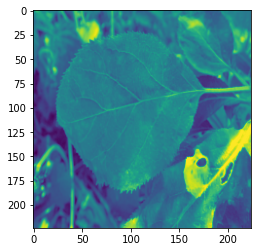

In [63]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
plt.imshow(images[0][0])
images[0][0].shape

### Create Model    

In [64]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [65]:
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler


model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, n_classes)

model = model.to(device)

c:\Users\steph\anaconda3\envs\ds_playground\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\steph\anaconda3\envs\ds_playground\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Define loss function and optimizer

In [66]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#### Train the model

In [68]:
import time
import os
import copy

num_epochs = 2

since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    phases = ['train', 'val']
    phases = ['train']
    for phase in phases:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in trainloader:
            # print('inputs_shape', inputs.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            # running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / len(trainloader)
        # epoch_acc = running_corrects.double() / len(trainloader)

        # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {0:.4f}')

        # deep copy the model
        # if phase == 'val' and epoch_acc > best_acc:
            # best_acc = epoch_acc
            # best_model_wts = copy.deepcopy(model.state_dict())

    print()

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:4f}')

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/1
----------
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])
inputs_shape torch.Size([4, 3, 224, 224])


KeyboardInterrupt: 